In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
# reading csv claimdata_utf8
# check number of observations and features
lar_loss = pd.read_csv('new_claimdata.csv', low_memory=False)
lar_loss.shape

(518077, 73)

In [3]:
def datetime(new_feature,feature,year,month,date):
    lar_loss[new_feature] = pd.to_datetime(lar_loss[feature])
    lar_loss[year] = lar_loss[new_feature].dt.year
    lar_loss[month] = lar_loss[new_feature].dt.month
    lar_loss[date] = lar_loss[new_feature].dt.day
    return lar_loss[year].head()

In [4]:
datetime('Event_Occurrence','Event_Occurrence_Month','Event_Occurrence_year','Event_Occurrence_month','Event_Occurrence_date')
datetime('Inception','Inception_Month','Inception_year', 'Inception_month','Inception_date')
datetime('Issued','Issued_Date','Issued_year','Issued_month','Issued_date')
datetime('Effective','Effective_Date','Effective_year','Effective_month','Effective_date')

0    2010
1    2010
2    2010
3    2010
4    2010
Name: Effective_year, dtype: int64

In [5]:
columns = list(lar_loss.columns)
feature_lst = ['EV_LARGE','Insured_Age_Range','Event_Occurrence','Event_Occurrence_Month',
              'Inception','Inception_Month','Issued','Issued_Date','Effective','Effective_Date',
              'Event_Number','Claim_Number','Incurred']
features_to_use = [col for col in columns if col not in feature_lst]
#features_to_use

In [6]:
X = lar_loss[features_to_use]
y = lar_loss['EV_LARGE']

# Modeling

#Ensemble methods: Random forest and XGBoost 

- using all features 

- no cross_validation

- no parameter tuning

- no regularization

#### First split into training and testing set

In [7]:
from sklearn.model_selection import train_test_split
training_features, test_features, \
training_target, test_target, = train_test_split(X,y,test_size = 0.25, random_state=50)

#### First split training set into X_train and X_validation

In [86]:
X_train, X_val, y_train, y_val = train_test_split(training_features, training_target,
                                                  test_size = 0.25,
                                                  random_state=50)

##### Then, SMOTE resampling

In [9]:
from imblearn.over_sampling import SMOTE
from collections import Counter
sm = SMOTE(random_state=50, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)

/Users/yingliu/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [10]:
from collections import Counter ## the entire dataset

print('Original dataset shape {}'.format(Counter(y)))
print(len(y))

Original dataset shape Counter({0: 466851, 1: 51226})
518077


In [11]:
### training part
print('Original dataset shape {}'.format(Counter(training_target)))
print(len(training_target))

Original dataset shape Counter({0: 349982, 1: 38575})
388557


In [12]:
### testing part
print('Original dataset shape {}'.format(Counter(test_target)))
print(len(test_target))

Original dataset shape Counter({0: 116869, 1: 12651})
129520


In [13]:
### y_train part after splitting
print('Original dataset shape {}'.format(Counter(y_train)))
print(len(y_train))

Original dataset shape Counter({0: 262504, 1: 28913})
291417


In [14]:
### y_val part
print('Original dataset shape {}'.format(Counter(y_val)))
print(len(y_val))

Original dataset shape Counter({0: 87478, 1: 9662})
97140


In [15]:
### y_train_res with respective to y_train part after resampling
print('Original dataset shape {}'.format(Counter(y_train_res)))
print(len(y_train_res))

Original dataset shape Counter({0: 262504, 1: 262504})
525008


### Random Forest Before resampling

In [16]:
# RanfomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
random_state = 50
rf = RandomForestClassifier(n_estimators=100, criterion='entropy',  n_jobs = 1,  random_state=random_state)
rf.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=50, verbose=0, warm_start=False)

### Modeling Evaluation

***AUC score***

In [62]:
### Validation Set
y_val_rf_pred_prob = rf.predict_proba(X_val)
print('Validation Results')
# print clf_rf.score(x_val, y_val)
print(roc_auc_score(y_val, y_val_rf_pred_prob[:, 1]))

### Testing part
y_test_rf_pred_prob = rf.predict_proba(test_features)
print ('\nTest Results')
print(roc_auc_score(test_target, y_test_rf_pred_prob[:, 1]))

Validation Results
0.932569910152

Test Results
0.933924671414


*** Recall Score ***

In [18]:
from sklearn.metrics import recall_score

### Validation Set

print('Validation Results')
# print(recall_score(y_val, rf.predict(X_val)))
print(recall_score(y_val, rf.predict(X_val),average = None))
### Testing part

print ('\nTest Results')
# print (recall_score(test_target, rf.predict(test_features)))
print(recall_score(test_target, rf.predict(test_features),average = None))


Validation Results
[ 0.99780516  0.67387704]

Test Results
[ 0.99806621  0.68018338]


In [19]:
# from sklearn.metrics import log_loss
# logloss = log_loss(y_val, y_val_pred_prob)
# logloss

### Random Forest after resampling

In [21]:
rf_resampling = RandomForestClassifier(n_estimators=100, criterion='entropy',  n_jobs = 1,  random_state=random_state)
rf_resampling.fit(x_train_res, y_train_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=50, verbose=0, warm_start=False)

### Evaluation after resampling

In [63]:
### AUC Score

### Validation Set
y_val_rf_res_pred_prob = rf_resampling.predict_proba(X_val)
print('AUC Score metric')
print('Validation Results')
# print clf_rf.score(x_val, y_val)
print(roc_auc_score(y_val, y_val_rf_res_pred_prob[:, 1]))

### Testing part
y_test_rf_res_pred_prob = rf_resampling.predict_proba(test_features)
print ('\nTest Results')
print(roc_auc_score(test_target, y_test_rf_res_pred_prob[:, 1]))

### Recall Score

### Validation Set
print('\nRecall Score metric')
print('Validation Results')
print(recall_score(y_val, rf_resampling.predict(X_val),average = None))
### Testing part

print ('\nTest Results')
# print (recall_score(test_target, rf.predict(test_features)))
print(recall_score(test_target, rf_resampling.predict(test_features),average = None))


AUC Score metric
Validation Results
0.930152537415

Test Results
0.932669195393

Recall Score metric
Validation Results
[ 0.9967992   0.68391637]

Test Results
[ 0.99722767  0.68911548]


### XGBoost Modeling

In [23]:
# XGBoost
from xgboost import XGBClassifier
random_state=50
xgb = XGBClassifier(seed=random_state)
xgb.fit(X_train, y_train)

/Users/yingliu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=50, silent=True, subsample=1)

### Modeling Evaluation

In [64]:
from sklearn.metrics import roc_auc_score
### Validation Set
y_val_xgb_pred_prob = xgb.predict_proba(X_val)
print('AUC Score')
print('Validation Results')
# print clf_rf.score(x_val, y_val)
print(roc_auc_score(y_val, y_val_xgb_pred_prob[:, 1]))

### Testing part
y_test_xgb_pred_prob = xgb.predict_proba(test_features)
print ('\nTest Results')
print(roc_auc_score(test_target, y_test_xgb_pred_prob[:, 1]))


# print recall_score(y_val, clf_rf.predict(x_val))

# print clf_rf.score(test_features, test_target)
# print recall_score(test_target, clf_rf.predict(test_features))

AUC Score
Validation Results
0.678912033306

Test Results
0.684678495171


In [65]:
from sklearn.metrics import recall_score

### Validation Set
print('Recall Score')
print('Validation Results')
# print(recall_score(y_val, rf.predict(X_val)))
print(recall_score(y_val, xgb.predict(X_val),average = None))
### Testing part

print ('\nTest Results')
# print (recall_score(test_target, rf.predict(test_features)))
print(recall_score(test_target, xgb.predict(test_features),average = None))


Recall Score
Validation Results
[ 0.99973708  0.0058994 ]

Test Results
[ 0.99975186  0.00497984]


### XGBoost after resampling

In [26]:
### Modeling after resampling
xgb_resampling = XGBClassifier(seed=random_state)
xgb_resampling.fit(x_train_res, y_train_res)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=50, silent=True, subsample=1)

### Evaluation after resampling

In [33]:
X_val_2 = X_val.as_matrix()

In [39]:
y_val_2 = y_val.as_matrix()

In [43]:
test_features_2 = test_features.as_matrix()
test_target_2 = test_target.as_matrix()

In [66]:
## AUC Score

## Validation Set
y_val_xgb_res_pred = xgb_resampling.predict_proba(X_val_2)
print('AUC Score')
print('Validation Results')
# print clf_rf.score(x_val, y_val)
print(roc_auc_score(y_val_2, y_val_xgb_res_pred[:, 1]))

# ## Testing part
y_test_xgb_res_pred = xgb_resampling.predict_proba(test_features_2)
print ('\nTest Results')
print(roc_auc_score(test_target_2, y_test_xgb_res_pred[:, 1]))

## Recall Score

### Validation Set
print('Recall Score')

print('Validation Results')
# print clf_rf.score(x_val, y_val)
print(recall_score(y_val_2, xgb_resampling.predict(X_val_2),average = None))

### Testing part

print ('\nTest Results')
print(recall_score(test_target_2, xgb_resampling.predict(test_features_2),average = None))

AUC Score
Validation Results
0.648172897328

Test Results
0.649756226594
Recall Score
Validation Results
[ 0.93000526  0.20275305]

Test Results
[ 0.92939103  0.20259268]


# Feature importance

- try to discover what features most contribute to predicting the large loss

- use Random forest and XGBoost

In [72]:
import numpy as np
importances = rf.feature_importances_
importances
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [73]:
# feature_lst_2 = ['EV_LARGE','Insured_Age_Range','Event_Occurrence','Event_Occurrence_Month',
#               'Inception','Inception_Month','Issued','Issued_Date','Effective','Effective_Date',
#               'Event_Number','Claim_Number','Incurred','Issued_Time','Effective_date','Event_Occurrence_month',
#                 'Issued_date']
# features_to_use = [col for col in columns if col not in feature_lst_2]
# #features_to_use

In [75]:
X = lar_loss[features_to_use]
y = lar_loss['EV_LARGE']

Feature ranking:
1. Annual_Premium (0.044452)
2. Annual_Premium_BIL (0.044134)
3. Annual_Premium_PDL (0.044024)
4. Issued_Time (0.043367)
5. Annual_Premium_PPA (0.042108)
6. Annual_Premium_PI (0.037424)
7. Insured_Age (0.036836)
8. Effective_date (0.034313)
9. Issued_date (0.033108)
10. Annual_Premium_OD (0.032603)
11. Event_Occurrence_month (0.032261)
12. Annual_Premium_ODPE (0.031812)
13. Annual_Premium_PE (0.031401)
14. Prefecture (0.031179)
15. Car_Age (0.028976)
16. Bonus_Malus (0.024339)
17. Issued_month (0.023333)
18. Renewal_Times (0.022723)
19. Effective_month (0.022553)
20. Inception_month (0.022218)
21. IN_OUTPATIENT (0.021042)
22. Original_Channel (0.017700)
23. PI_Class (0.017660)
24. Region (0.014599)
25. PI_Limit (0.013084)
26. Insured_Age_Range_Num (0.012958)
27. Bonus_Malus_Range (0.012289)
28. Family_Restriction (0.011897)
29. Reason (0.010575)
30. Car_Type (0.010300)
31. Payment_Method (0.009979)
32. Prev_Insurer_Category (0.009922)
33. Event_Occurrence_year (0.00988

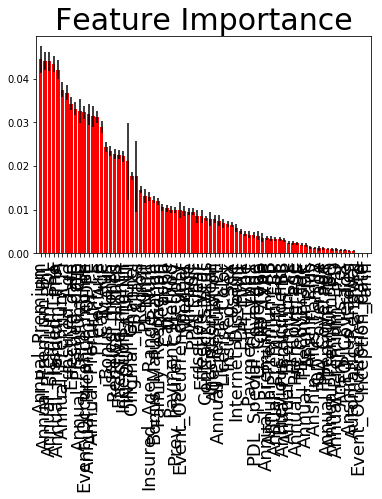

In [76]:
# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))
# Plot the feature importances of the forest
plt.title("Feature Importance", size = 30)
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]),X.columns[indices], size =18)
plt.xlim([-1, X.shape[1]])
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

### Visualization Evaluation

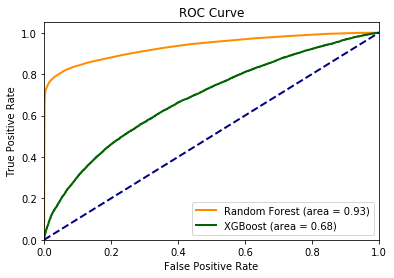

In [111]:
from sklearn import metrics
import matplotlib.pyplot as plt
% matplotlib inline

# random forest
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(test_target, y_test_rf_pred_prob[:, 1], pos_label=1)
rf_roc_auc = metrics.auc(fpr_rf,tpr_rf)

# plt.plot(fpr_rf,tpr_rf, color="blue")

# XGBoost
fpr_xgb, tpr_xgb, thresholds_xgb = metrics.roc_curve(test_target, y_test_xgb_pred_prob[:, 1], pos_label=1)
xgb_roc_auc = metrics.auc(fpr_xgb,tpr_xgb)

# plt.plot(fpr_xgb, tpr_xgb, color="green")


plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange',
         lw=2, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot(fpr_xgb, tpr_xgb, color='darkgreen',
         lw=2, label='XGBoost (area = %0.2f)' % xgb_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# XGBoost
import xgboost as xgb
xgb_params = {"objective": "reg:linear", "eta": 0.01, "max_depth": 10, "seed": 42, "silent": 1,
             'colsample_bytree':0.9, 'gamma':0.3,  'min_child_weight':4,
                     'reg_alpha':0.65, 'reg_lambda':5, 'subsample':0.9}
num_rounds = 1000

dtrain =  xgb.DMatrix(X_train, label=y_train)
gbdt =  xgb.train(xgb_params, dtrain, num_rounds)

/Users/yingliu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


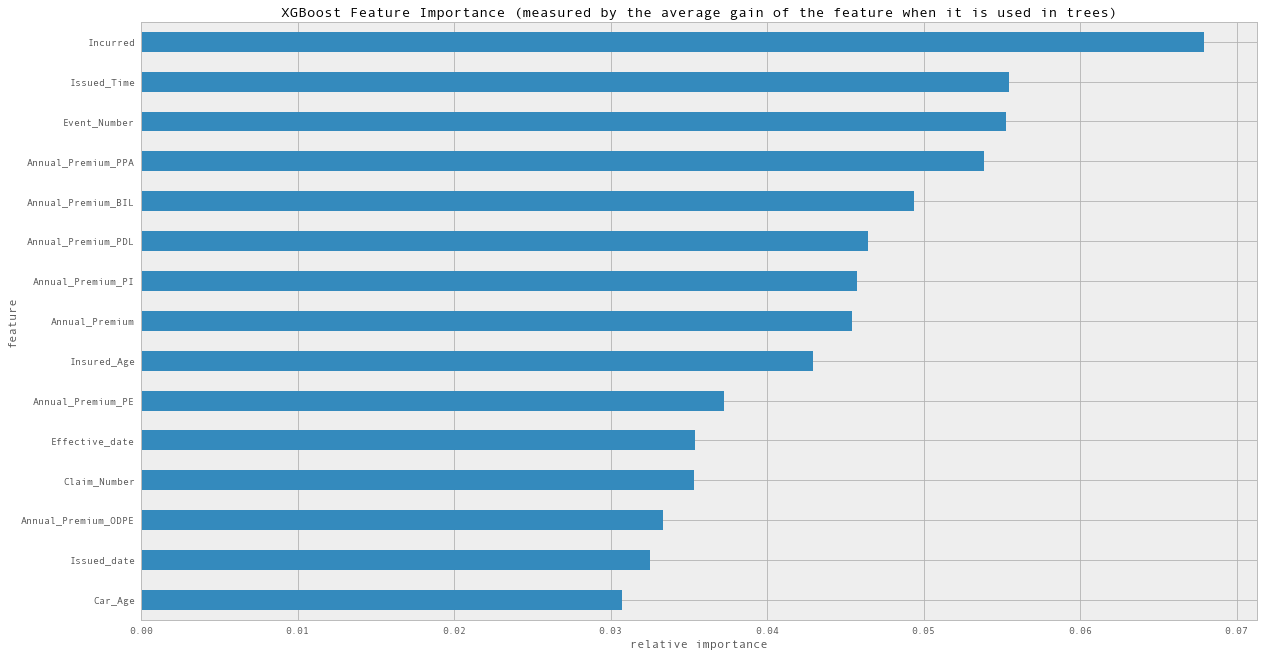

In [23]:
importance = gbdt.get_score(importance_type='weight')
importance = sorted(importance.items(), key = lambda x:x[1], reverse = True)
df = pd.DataFrame(importance, columns=['feature', 'fscore']).sort_values(by = 'fscore')
df['fscore'] = df['fscore'] / df['fscore'].sum()

plt.figure()
df[-15:].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(20, 11))
plt.title('XGBoost Feature Importance (measured by the average gain of the feature when it is used in trees)')
plt.xlabel('relative importance')
plt.savefig('_FeatureImportance_weight.png')

### Parameter tuning

In [107]:
print(xgb.get_params())

{'base_score': 0.5, 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'nthread': -1, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 50, 'silent': True, 'subsample': 1}


In [108]:
params = {
        'learning_rate': [0.03, 0.01, 0.03],
        'max_depth': [3,4,5],
        'subsample': [0.7],
        'colsample_bytree': [0.7],
        'objective': ['reg:linear'],
        'n_estimators': [100,300,500],
        'gamma':[0]}

gs_xgb = GridSearchCV(estimator=xgb, param_grid=params, cv=3, scoring='roc_auc')
gs_xgb.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=50, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.03, 0.01, 0.03], 'max_depth': [3, 4, 5], 'subsample': [0.7], 'colsample_bytree': [0.7], 'objective': ['reg:linear'], 'n_estimators': [100, 300, 500], 'gamma': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [110]:
gs_xgb.best_params_

{'colsample_bytree': 0.7,
 'gamma': 0,
 'learning_rate': 0.03,
 'max_depth': 5,
 'n_estimators': 500,
 'objective': 'reg:linear',
 'subsample': 0.7}

In [112]:
random_state = 50
final_xgb_model = XGBClassifier(**gs_xgb.best_params_,seed=random_state).fit(X_train,y_train)

In [114]:
from sklearn.metrics import roc_auc_score
### Validation Set
y_val_xgb_gs_pred = final_xgb_model.predict_proba(X_val)
print('AUC Score')
print('Validation Results')
# print clf_rf.score(x_val, y_val)
print(roc_auc_score(y_val, y_val_xgb_gs_pred[:, 1]))

### Testing part
y_test_xgb_gs_pred = final_xgb_model.predict_proba(test_features)
print ('\nTest Results')
print(roc_auc_score(test_target, y_test_xgb_gs_pred[:, 1]))


from sklearn.metrics import recall_score

### Validation Set

print('Validation Results')
# print(recall_score(y_val, rf.predict(X_val)))
print(recall_score(y_val, final_xgb_model.predict(X_val),average = None))
### Testing part

print ('\nTest Results')
# print (recall_score(test_target, rf.predict(test_features)))
print(recall_score(test_target, final_xgb_model.predict(test_features),average = None))


AUC Score
Validation Results
0.71607577305

Test Results
0.722384459009
Validation Results
[ 0.99970278  0.01604223]

Test Results
[ 0.99968341  0.01762707]


In [116]:
final_xgb_model = XGBClassifier(**gs_xgb.best_params_,seed=random_state).fit(x_train_res,y_train_res)

In [118]:
from sklearn.metrics import roc_auc_score
### Validation Set
y_val_xgb_gs_res = final_xgb_model.predict_proba(X_val_2)
print('AUC Score')
print('Validation Results')
# print clf_rf.score(x_val, y_val)
print(roc_auc_score(y_val, y_val_xgb_gs_res[:, 1]))

### Testing part
y_test_xgb_gs_res = final_xgb_model.predict_proba(test_features_2)
print ('\nTest Results')
print(roc_auc_score(test_target, y_test_xgb_gs_res[:, 1]))


from sklearn.metrics import recall_score

### Validation Set

print('Validation Results')
# print(recall_score(y_val, rf.predict(X_val)))
print(recall_score(y_val, final_xgb_model.predict(X_val_2),average = None))
### Testing part

print ('\nTest Results')
# print (recall_score(test_target, rf.predict(test_features)))
print(recall_score(test_target, final_xgb_model.predict(test_features_2),average = None))


AUC Score
Validation Results
0.693815530892

Test Results
0.698613851655
Validation Results
[ 0.97480509  0.14738149]

Test Results
[ 0.97545115  0.15318947]


In [95]:
## Random Forest
## default parameters
print(rf.get_params())

{'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 1, 'oob_score': False, 'random_state': 50, 'verbose': 0, 'warm_start': False}


In [100]:
from sklearn.model_selection import GridSearchCV
params={
        'n_estimators':[100,200,300],
        'max_features':[0.1,0.3,0.5,0.7],
        'max_depth':[4]}
gs_rft = GridSearchCV(estimator=rf,param_grid=params,cv=3, scoring='roc_auc')   
gs_rft.fit(X_train,y_train)



GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=50, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200, 300], 'max_features': [0.1, 0.3, 0.5, 0.7], 'max_depth': [4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [101]:
gs_rft.best_params_

{'max_depth': 4, 'max_features': 0.7, 'n_estimators': 300}

In [103]:
final_rf_model = RandomForestClassifier(**gs_rft.best_params_,random_state=50,n_jobs=-1,class_weight='balanced').fit(X_train,y_train)

In [ ]:
#### before sampling

In [104]:
from sklearn.metrics import roc_auc_score
### Validation Set
y_val_rf_gs_pred = final_rf_model.predict_proba(X_val)
print('AUC Score')
print('Validation Results')
# print clf_rf.score(x_val, y_val)
print(roc_auc_score(y_val, y_val_rf_gs_pred[:, 1]))

### Testing part
y_test_rf_gs_pred = final_rf_model.predict_proba(test_features)
print ('\nTest Results')
print(roc_auc_score(test_target, y_test_rf_gs_pred[:, 1]))


from sklearn.metrics import recall_score

### Validation Set

print('Validation Results')
# print(recall_score(y_val, rf.predict(X_val)))
print(recall_score(y_val, final_rf_model.predict(X_val),average = None))
### Testing part

print ('\nTest Results')
# print (recall_score(test_target, rf.predict(test_features)))
print(recall_score(test_target, final_rf_model.predict(test_features),average = None))


AUC Score
Validation Results
0.665673133801

Test Results
0.670955452475
Validation Results
[ 0.60619813  0.63278824]

Test Results
[ 0.60251221  0.6401075 ]


In [105]:
final_rf_res_model = RandomForestClassifier(**gs_rft.best_params_,random_state=50,n_jobs=-1,class_weight='balanced').fit(x_train_res,y_train_res)

In [ ]:
### after sampling

In [113]:
from sklearn.metrics import roc_auc_score
### Validation Set
y_val_rf_gs_res = final_rf_res_model.predict_proba(X_val)
print('AUC Score')
print('Validation Results')
# print clf_rf.score(x_val, y_val)
print(roc_auc_score(y_val, y_val_rf_gs_res[:, 1]))

### Testing part
y_test_rf_gs_res = final_rf_res_model.predict_proba(test_features)
print ('\nTest Results')
print(roc_auc_score(test_target, y_test_rf_gs_res[:, 1]))


from sklearn.metrics import recall_score

### Validation Set

print('Validation Results')
# print(recall_score(y_val, rf.predict(X_val)))
print(recall_score(y_val, final_rf_res_model.predict(X_val)))
### Testing part

print ('\nTest Results')
# print (recall_score(test_target, rf.predict(test_features)))
print(recall_score(test_target, final_rf_res_model.predict(test_features),average = None))

AUC Score
Validation Results
0.649028722407

Test Results
0.652197258231
Validation Results
0.221279238253

Test Results
[ 0.91464802  0.22464627]


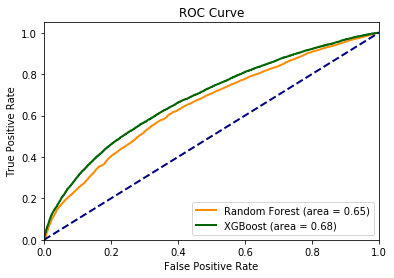

In [115]:
## ROC Curve
from sklearn import metrics
import matplotlib.pyplot as plt
% matplotlib inline

# random forest
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(test_target, y_test_rf_gs_res[:, 1], pos_label=1)
rf_roc_auc = metrics.auc(fpr_rf,tpr_rf)

# plt.plot(fpr_rf,tpr_rf, color="blue")

# XGBoost
fpr_xgb, tpr_xgb, thresholds_xgb = metrics.roc_curve(test_target, y_test_xgb_pred_prob[:, 1], pos_label=1)
xgb_roc_auc = metrics.auc(fpr_xgb,tpr_xgb)

# plt.plot(fpr_xgb, tpr_xgb, color="green")


plt.figure()
plt.plot(fpr_rf, tpr_rf, color='darkorange',
         lw=2, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot(fpr_xgb, tpr_xgb, color='darkgreen',
         lw=2, label='XGBoost (area = %0.2f)' % xgb_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()